Using device: cuda
Pre-creating output directories...

🚀 Processing video folder: video-02menang-20240122061552-7326802529356893446 (1/100)

✅ Done with: video-02menang-20240122061552-7326802529356893446
Moving results to: C:/Users/yehte/Downloads/Ye Htet/Projects/TikTok/zero_shot_face_recognition/fourth_discussion/2024_general_election_finetune\KIM\PDIP\Gibran Rakabuming Raka\video-02menang-20240122061552-7326802529356893446

🚀 Processing video folder: video-02menang-20240131125449-7330245100531993861 (2/100)

✅ Done with: video-02menang-20240131125449-7330245100531993861
Moving results to: C:/Users/yehte/Downloads/Ye Htet/Projects/TikTok/zero_shot_face_recognition/fourth_discussion/2024_general_election_finetune\KPP\Independent\Anies Rasyid Baswedan\video-02menang-20240131125449-7330245100531993861

🚀 Processing video folder: video-2024prabow-20231006103222-7286791431040093446 (3/100)

✅ Done with: video-2024prabow-20231006103222-7286791431040093446
Moving results to: C:/Users/yehte/

KeyboardInterrupt: 

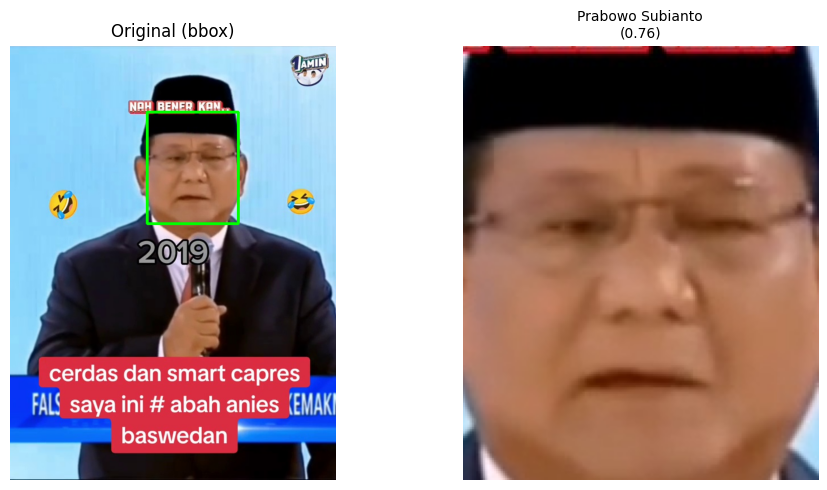

In [3]:
import os
import cv2
import torch
import open_clip
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
from collections import Counter
import time
import csv
import pandas as pd
import shutil

# Setup device for computations (CUDA if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load OpenCLIP model and its preprocessor
# 'ViT-B-16' is the model architecture, 'laion400m_e32' is the pretrained weights
model, _, preprocess = open_clip.create_model_and_transforms(
    'ViT-B-16-quickgelu', pretrained='openai', device=device)

# load the fine-tuned model
# Ensure the correct path to your fine-tuned model weights
model.load_state_dict(torch.load("finetuned_identity_only_best_ViT-B-16_openai.pt")); model.to(device=device).eval()

# Get the tokenizer specific to the loaded model
tokenizer = open_clip.get_tokenizer('ViT-B-16')

# Text prompts for identity - EXPANDED LIST
face_prompts = [
    "A face of Soekarno, a male First President (1945-1967) from Indonesia.",
    "A face of Suharto, a male Second President (1967-1998) from Indonesia.",
    "A face of Baharuddin Jusuf Habibie, a male Third President (1998-1999) from Indonesia.",
    "A face of Abdurrahman Wahid, a male Fourth President (1999-2001) from Indonesia.",
    "A face of Megawati Sukarnoputri, a female Fifth President (2001-2004) from Indonesia.",
    "A face of Susilo Bambang Yudhoyono, a male Sixth President (2004-2014) from Indonesia.",
    "A face of Joko Widodo, a male Seventh President (2014-2024) from Indonesia.",
    "A face of Prabowo Subianto, a male Eight President (2024-Present) from Indonesia.",
    "A face of Anies Rasyid Baswedan, a male Governor of Jakarta (2017-2022) and Presidential Candidate Election (2024) from Indonesia.",
    "A face of Ganjar Pranowo, a male Governor of Central Java (2013-2023) and Presidential Candidate Election (2024) from Indonesia.",
    "A face of Gibran Rakabuming Raka, a male Vice President (2024-2029) from Indonesia.",
    "A face of Maruf Amin, a male Vice President (2019-2024) from Indonesia.",
    "A face of Airlangga Hartarto, a male Coordinating Minister of Economic Affairs (2024-2029) from Indonesia.",
    "A face of Sri Mulyani Indrawati, a female Minister of Finance (2024-2029) from Indonesia.",
    "A face of Erick Thohir, a male Minister of State Owned Entreprises (2024-2029) from Indonesia.",
    "A face of Agus Harimurti Yudhoyono, a male Coordinating Minister of Agrarian Affairs and Spatial Planning (2024-2029) and Chairman of Democratic Party from Indonesia.",
    "A face of Muhaimin Iskandar, a male Coordinating Minister of Social Empowrement (2024-2029) and Chairman of National Awakening Party from Indonesia.",
    "A face of Mahfud MD, a male Coordinating Minister of Political, Legal, and Security Affairs (2019-2024) from Indonesia.",
    "A face of Boediono, a male Vice President (2009-2014) from Indonesia.",
    "A face of Jusuf Kalla, a male Vice President (2004-2009) and Vice President (2014-2019) from Indonesia.",
    f"A face of Unknown Person, who is not a politician."
]

# Extract simplified labels from face prompts (e.g., "Soekarno" from "A face of Soekarno, ...")
labels = [p.replace("A face of ", "").split(",")[0] for p in face_prompts]
label_list = ["Soekarno", "Suharto", "Baharuddin Jusuf Habibie", "Abdurrahman Wahid", "Megawati Sukarnoputri", "Susilo Bambang Yudhoyono", "Joko Widodo",
               "Prabowo Subianto", "Anies Rasyid Baswedan", "Ganjar Pranowo", "Gibran Rakabuming Raka", "Maruf Amin", "Airlangga Hartarto",
               "Sri Mulyani Indrawati", "Erick Thohir", "Agus Harimurti Yudhoyono", "Muhaimin Iskandar", "Mahfud MD", "Boediono", "Jusuf Kalla", "Unknown Person"]
# Create a mapping from extracted labels to their consistent keys
label_map = dict(zip(labels, label_list))

# --- REFINED: Folder Structure and Reverse Mapping ---
coalitions = {
    "KPP": [{"Independent": ["Anies Rasyid Baswedan"]},
            {"PKB": ["Muhaimin Iskandar", "Abdurrahman Wahid"]}],
    "KIM": [{"Independent": ["Erick Thohir"]},
            {"PDIP": ["Gibran Rakabuming Raka"]},
            {"Gerindra": ["Prabowo Subianto"]},
            {"Demokrat": ["Agus Harimurti Yudhoyono", "Susilo Bambang Yudhoyono"]},
            {"Golkar": ["Airlangga Hartarto", "Baharuddin Jusuf Habibie",  "Jusuf Kalla", "Suharto"]}],
    "KSP3GP": [{"Independent": ["Mahfud MD"]},
               {"PDIP": ["Ganjar Pranowo", "Megawati Sukarnoputri", "Joko Widodo", "Soekarno"]}],
    "Others": [{"Independent": ["Sri Mulyani Indrawati", "Boediono", "Maruf Amin"]}]
}

# Create a reverse lookup map from person to their coalition and party
person_to_party_map = {}
for coalition, parties in coalitions.items():
    for party_dict in parties:
        for party, members in party_dict.items():
            for member in members:
                # Use the consistent name from label_map for lookup
                person_key = label_map.get(member, member)
                person_to_party_map[person_key] = (coalition, party)


# Tokenize prompts
text_tokens = tokenizer(face_prompts).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

# Load YOLOv8 face detector
face_model = YOLO("yolov8l-face-lindevs.pt")
face_model.to(device)

# Final summary list
final_summary = []

# Helper function
def classify_with_clip(image_pil):
    try:
        image_pil = image_pil.convert("RGB")
        image_input = preprocess(image_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image_input)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)[0].cpu().numpy()
    except Exception as e:
        print(f"[ERROR] classify_with_clip failed: {e}")
        return "Unknown Person", 0.0

    identity_sim = similarity[:len(labels)]
    identity_idx = np.argmax(identity_sim)
    confidence = identity_sim[identity_idx]

    predicted_identity = labels[identity_idx] if confidence > 0.7 else "Unknown Person"
    return predicted_identity, confidence

# Define parent folders
parent_input_dir = "C:/Users/yehte/Downloads/Ye Htet/Projects/TikTok/zero_shot_face_recognition/third_discussion/extracted_frames"
parent_output_dir = "C:/Users/yehte/Downloads/Ye Htet/Projects/TikTok/zero_shot_face_recognition/fourth_discussion/2024_general_election_finetune"

# --- REFINED: Pre-create all destination directories ---
print("Pre-creating output directories...")
for coalition, parties in coalitions.items():
    for party_dict in parties:
        for party in party_dict.keys():
            os.makedirs(os.path.join(parent_output_dir, coalition, party), exist_ok=True)
# Create a folder for uncategorized videos
os.makedirs(os.path.join(parent_output_dir, "Uncategorized"), exist_ok=True)


# --- MODIFIED: Counters for periodic saving ---
processed_video_count = 0
summary_file_counter = 0
video_folders = os.listdir(parent_input_dir)[:100]
total_videos = len(video_folders)

# Process each video folder
for video_folder_name in video_folders:
    input_folder = os.path.join(parent_input_dir, video_folder_name)
    if not os.path.isdir(input_folder):
        continue

    # Create the initial result folder at the top level
    result_folder = os.path.join(parent_output_dir, video_folder_name)
    os.makedirs(result_folder, exist_ok=True)

    print(f"\n🚀 Processing video folder: {video_folder_name} ({processed_video_count + 1}/{total_videos})")

    identity_counter = Counter()

    csv_path = os.path.join(result_folder, "inference_log.csv")
    csv_file = open(csv_path, mode='w', newline='', encoding='utf-8')
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["frame_name", "face_identity", "confidence", "inference_time_sec"])

    start_time = time.time()

    image_files = sorted([f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.png'))])
    original_video_length_sec = len(image_files)

    for filename in image_files:
        image_path = os.path.join(input_folder, filename)
        bgr_img = cv2.imread(image_path)
        if bgr_img is None:
            print(f"Warning: Could not read image {image_path}, skipping.")
            continue
        rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        draw_img = rgb_img.copy()

        results = face_model.predict(image_path, conf=0.7, verbose=False)
        boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

        if len(boxes) == 0:
            continue

        # Limit plotting to avoid overwhelming memory for videos with many faces
        if len(boxes) < 10:
            fig, axs = plt.subplots(1, len(boxes) + 1, figsize=(5 * (len(boxes) + 1), 5))
            for i, (x1, y1, x2, y2) in enumerate(boxes):
                face = rgb_img[y1:y2, x1:x2]
                face_pil = Image.fromarray(face).convert("RGB")

                face_start = time.time()
                predicted, confidence = classify_with_clip(face_pil)
                face_end = time.time()
                face_inference_time = face_end - face_start

                if predicted != "Unknown Person":
                    identity_counter[predicted] += 1

                csv_writer.writerow([filename.split("_")[-1], predicted, f"{confidence:.4f}", f"{face_inference_time:.4f}"])

                axs[i + 1].imshow(face)
                axs[i + 1].set_title(f"{predicted}\n({confidence:.2f})", fontsize=10)
                axs[i + 1].axis("off")

                cv2.rectangle(draw_img, (x1, y1), (x2, y2), (0, 255, 0), 3)

            axs[0].imshow(draw_img)
            axs[0].set_title("Original (bbox)")
            axs[0].axis("off")

            plt.tight_layout()
            save_vis_path = os.path.join(result_folder, filename.split("_")[-1])
            plt.savefig(save_vis_path, dpi=100)
            plt.close('all')

    end_time = time.time()
    total_time_sec = end_time - start_time
    csv_file.close()

    main_character = identity_counter.most_common(1)[0][0] if identity_counter else "None"

    summary_path = os.path.join(result_folder, "summary.txt")
    with open(summary_path, "w", encoding="utf-8") as f:
        f.write("Face Appearance Summary (Most Frequent Identity in Video Sequence)\n")
        f.write("=" * 65 + "\n\n")

        if identity_counter:
            sorted_identities = identity_counter.most_common()
            total_count = sum(identity_counter.values())
            for name, count in sorted_identities:
                percentage = (count / total_count) * 100
                f.write(f"{name:<30} : {count:>3} times ({percentage:5.1f}%)\n")
            f.write("\n" + "-" * 65 + "\n")
            f.write(f"🟩 Most Frequently Appearing: {main_character} ({sorted_identities[0][1]} times)\n")
        else:
            f.write("❗ No known person detected frequently enough in the video sequence.\n")
        f.write("\nTotal Inference Time: {:.2f} minutes\n".format(total_time_sec / 60))

    summary_row = {"video_folder": video_folder_name}
    summary_row["main_character"] = main_character
    summary_row.update({k: 0 for k in label_list})
    for name, count in identity_counter.items():
        k = label_map.get(name, "Unknown Person")
        if k != "Unknown Person":
            summary_row[k] = count
    summary_row["original_video_length_sec"] = original_video_length_sec
    summary_row["inference_time_sec"] = f"{total_time_sec:.2f}"
    final_summary.append(summary_row)

    print(f"\n✅ Done with: {video_folder_name}")

    # --- REFINED: Move the processed folder to its final destination ---
    if main_character != "None" and main_character in person_to_party_map:
        coalition, party = person_to_party_map[main_character]
        destination_dir = os.path.join(parent_output_dir, coalition, party, main_character, video_folder_name)
        print(f"Moving results to: {destination_dir}")
        try:
            shutil.move(result_folder, destination_dir)
        except shutil.Error as e:
            print(f"Could not move folder {video_folder_name}. It may already exist in the destination. Error: {e}")
    else:
        destination_dir = os.path.join(parent_output_dir, "Uncategorized", video_folder_name)
        print(f"Main character '{main_character}' not in map or not found. Moving results to: {destination_dir}")
        try:
            shutil.move(result_folder, destination_dir)
        except shutil.Error as e:
            print(f"Could not move folder {video_folder_name} to Uncategorized. Error: {e}")


    # --- MODIFIED: Periodic saving logic ---
    processed_video_count += 1
    if processed_video_count % 100 == 0 and processed_video_count > 0:
        summary_file_counter += 1
        summary_filename = f"final_summary_{summary_file_counter:02d}.csv"
        final_summary_csv = os.path.join(parent_output_dir, summary_filename)

        print(f"\n💾 Checkpoint: Saving summary for videos {processed_video_count-99}-{processed_video_count}...")
        df = pd.DataFrame(final_summary)
        df.to_csv(final_summary_csv, index=False, encoding="utf-8")
        print(f"📝 Intermediate summary saved to: {final_summary_csv}")

        final_summary = []


# --- FINAL SAVE: Save any remaining data after the loop finishes ---
if final_summary:
    print("\n🏁 All videos processed. Performing final save of remaining summary...")
    summary_file_counter += 1
    summary_filename = f"final_summary_{summary_file_counter:02d}.csv"
    final_summary_csv = os.path.join(parent_output_dir, summary_filename)

    df = pd.DataFrame(final_summary)
    df.to_csv(final_summary_csv, index=False, encoding="utf-8")
    print(f"\n📝 Final summary saved to: {final_summary_csv}")
else:
    print("\n🏁 All videos processed. No remaining data to save in a final chunk.")
